4# Steps

1. We have $\rho_0$ to be pure, a Beam Splitter modelled 

1. Build a `RunOptions` generator with the parameters of interest, namely $dim_S, J_S, \delta_S, U_S, dim_A, J_A, \delta_A, U_A, \alpha_{xx}, \alpha_{xz}, \alpha_{zx}, \alpha_{zz}, t$. We need a decent range for $\delta_S$ for the Bayesian update side of things. We assume a uniform prior on the cartesian product.
2. Calculate the probabilities for the $J_z$ measurement for each value. This is a `dict`, as $J_z$ can have multiple outcomes.
3. Use the probabilities to build the expected likelihood function over all inputs, for a given range of $N_{trials}$. This also requires a "True" set of values for each parameter.
4. Use the likelihood to build the marginal distribution for all variables.
5. Save the std variation for each estimated variable!
6. Plot $\Delta$ against the $N_{trials}$, keeping the parameters of the plot saved

# Imports

In [17]:

from dataclasses import dataclass, field
from matplotlib.pyplot import figure
from src.angular_momentum import generate_spin_matrices
from tqdm import tqdm
import functools
import itertools
import numpy as np
import pandas as pd
import scipy

figure(figsize=(16, 6))

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

<Figure size 1600x600 with 0 Axes>

In [18]:
@dataclass
class Settings:
    dim_s: int
    dim_a: int
    probability_error_tolerance: float
    system_jx: np.array = field(init=False)
    system_jz: np.array = field(init=False)
    ancilla_jx: np.array = field(init=False)
    ancilla_jz: np.array = field(init=False)
    initial_state: np.array = field(init=False)

    def __post_init__(self):
        self.system_jx, self.system_jz = generate_spin_matrices(dim=self.dim_s)
        self.ancilla_jx, self.ancilla_jz = generate_spin_matrices(dim=self.dim_a)
        self.initial_state = np.zeros(self.dim_s * self.dim_a)
        self.initial_state[0] = 1
        self.initial_state = np.outer(self.initial_state, self.initial_state)

    def generate_hamiltonian(
        self,
        j_s: float,
        u_s: float,
        delta_s: float,
        j_a: float,
        u_a: float,
        delta_a: float,
        alpha_xx: float,
        alpha_xz: float,
        alpha_zx: float,
        alpha_zz: float,
    ) -> np.array:
        system_hamiltonian = np.kron(
            -1 * j_s * self.system_jx + u_s * self.system_jz @ self.system_jz + delta_s * self.system_jz,
            np.divide(np.eye(self.dim_a), self.dim_a)
        )
        ancillary_hamiltonian = np.kron(
            np.divide(np.eye(self.dim_s), self.dim_s),
            -1 * j_a * self.ancilla_jx + u_a * self.ancilla_jz @ self.ancilla_jz + delta_a * self.ancilla_jz
        )
        interaction_hamiltonian = functools.reduce(
            lambda x, y: x + y,
            [
                alpha_xx * np.kron(self.system_jx, self.ancilla_jx),
                alpha_xz * np.kron(self.system_jx, self.ancilla_jz),
                alpha_zx * np.kron(self.system_jz, self.ancilla_jx),
                alpha_zz * np.kron(self.system_jz, self.ancilla_jz),
            ]
        )
        return system_hamiltonian + ancillary_hamiltonian + interaction_hamiltonian

    def trace_out_ancillary(self, state: np.array):
        return np.trace(
            np.array(state).reshape(self.dim_s, self.dim_a, self.dim_s, self.dim_a),
            axis1=1,
            axis2=3
        )

    @staticmethod
    def calculate_final_state(
        hamiltonian: np.array,
        initial_state: np.ndarray,
        t: float = 0,
    ) -> np.array:
        return scipy.linalg.expm(-1j * t * hamiltonian) @ initial_state @ scipy.linalg.expm(1j * t * hamiltonian)

    def calculate_probabilities(self, final_state: np.array) -> np.array:
        system_state = self.trace_out_ancillary(state=final_state)
        probabilities = [np.abs(x)**2 for x in np.diag(system_state)] # TODO: Ensure these actually up to 1!!!
        # assert np.abs(np.sum(probabilities) - 1) < settings.probability_error_tolerance, f"⚠ The observed probabilities {probabilities} are unphysical by {np.abs(np.sum(probabilities) - 1):.5f}%"
        return probabilities

# Initial state $\ket{0} \otimes \ket{0}$

In [19]:
settings = Settings(
    dim_s= 2,
    dim_a= 1,
    probability_error_tolerance= .001,
)
pd.DataFrame(settings.initial_state).style.background_gradient(cmap='viridis')

,0,1
0,1.000000,0.000000
1,0.000000,0.000000


# Build Generator Object

In [20]:
df = pd.DataFrame([
    {
        "j_s": j_s,
        "u_s": u_s,
        "delta_s": delta_s,
        "j_a": j_a,
        "u_a": u_a,
        "delta_a": delta_a,
        "alpha_xx": alpha_xx,
        "alpha_xz": alpha_xz,
        "alpha_zx": alpha_zx,
        "alpha_zz": alpha_zz,
        "time": time
    }
    for j_s, u_s, delta_s, j_a, u_a, delta_a, alpha_xx, alpha_xz, alpha_zx, alpha_zz, time
    in itertools.product(
        np.linspace(.1999, .2001, 11), # j_s: float,
        np.linspace(.0999, .1001, 11), # u_s: float,
        np.linspace(1.1, 1.3, 1001), # delta_s: float,
        [.3], # j_a: float,
        [.1], # u_a: float,
        [1], # delta_a: float,
        [0], # alpha_xx: float,
        [0], # alpha_xz: float,
        [0], # alpha_zx: float,
        [0], # alpha_zz: float,
        np.linspace(4.99, 5.01, 3), # time: float
    )],
)
df.sample(10).style.background_gradient(cmap='viridis', axis=0)

,j_s,u_s,delta_s,j_a,u_a,delta_a,alpha_xx,alpha_xz,alpha_zx,alpha_zz,time
281523,0.200060,0.100000,1.249600,0.300000,0.100000,1,0,0,0,0,4.990000
35477,0.199920,0.099900,1.262800,0.300000,0.100000,1,0,0,0,0,5.010000
156913,0.199980,0.100060,1.150400,0.300000,0.100000,1,0,0,0,0,5.000000
131385,0.199960,0.100100,1.250400,0.300000,0.100000,1,0,0,0,0,4.990000
285001,0.200060,0.100020,1.281200,0.300000,0.100000,1,0,0,0,0,5.000000
342571,0.200100,0.099980,1.115200,0.300000,0.100000,1,0,0,0,0,5.000000
243697,0.200040,0.099980,1.130200,0.300000,0.100000,1,0,0,0,0,5.000000
28309,0.199900,0.100080,1.185400,0.300000,0.100000,1,0,0,0,0,5.000000
286914,0.200060,0.100040,1.208600,0.300000,0.100000,1,0,0,0,0,4.990000
223778,0.200020,0.100060,1.203600,0.300000,0.100000,1,0,0,0,0,5.010000


# Define True System

In [21]:
true_values = {
    "j_s": .2,
    "u_s": .1,
    "delta_s": 1.2,
    "j_a": .3,
    "u_a": .1,
    "delta_a": 1,
    "alpha_xx": 0,
    "alpha_xz": 0,
    "alpha_zx": 0,
    "alpha_zz": 0,
    "time": 5,
}

# Calculate measurement probabilities

In [22]:
def calculate_measurement_probabilities(row: dict) -> np.array:
    hamiltonian = settings.generate_hamiltonian(
        j_s = row["j_s"],
        u_s = row["u_s"],
        delta_s = row["delta_s"],
        j_a = row["j_a"],
        u_a = row["u_a"],
        delta_a = row["delta_a"],
        alpha_xx = row["alpha_xx"],
        alpha_xz = row["alpha_xz"],
        alpha_zx = row["alpha_zx"],
        alpha_zz = row["alpha_zz"]
    )
    final_state = settings.calculate_final_state(
        hamiltonian = hamiltonian,
        initial_state = settings.initial_state,
        t = row["time"],
    )
    # return final_state
    measurement_probabilities = settings.calculate_probabilities(final_state)
    return measurement_probabilities
    # return np.divide(final_probabilities, np.sum(final_probabilities))

In [23]:
df["probabilities"] = df.progress_apply(calculate_measurement_probabilities, axis=1) # i.e. Prob[J_z=k] for k in range(0, dim_s)
df["final_state_error"] = df.progress_apply(lambda row: np.abs(np.sum(row["probabilities"]) - 1), axis=1)

df.sample(30).style.background_gradient(cmap='viridis', axis=0)

100%|██████████| 363363/363363 [00:03<00:00, 119923.37it/s]


,j_s,u_s,delta_s,j_a,u_a,delta_a,alpha_xx,alpha_xz,alpha_zx,alpha_zz,time,probabilities,final_state_error
207856,0.200020,0.099960,1.143200,0.300000,0.100000,1,0,0,0,0,5.000000,"[0.9966413326398994, 2.824907566395795e-06]",0.003356
145858,0.199980,0.099980,1.214200,0.300000,0.100000,1,0,0,0,0,5.000000,"[0.9997758110847917, 1.2566576108513323e-08]",0.000224
190406,0.200000,0.100060,1.181000,0.300000,0.100000,1,0,0,0,0,5.010000,"[0.9988980756066548, 3.0372670715850385e-07]",0.001102
316983,0.200080,0.100020,1.211200,0.300000,0.100000,1,0,0,0,0,4.990000,"[0.9996717017941388, 2.6949351886656882e-08]",0.000328
182233,0.200000,0.100000,1.236800,0.300000,0.100000,1,0,0,0,0,5.000000,"[0.9999954712326318, 5.127445078618988e-12]",0.000005
56478,0.199920,0.100040,1.261600,0.300000,0.100000,1,0,0,0,0,4.990000,"[0.9998991991520908, 2.540330770137304e-09]",0.000101
65390,0.199920,0.100100,1.255000,0.300000,0.100000,1,0,0,0,0,5.010000,"[0.9999134843248997, 1.8713214597566662e-09]",0.000087
276389,0.200060,0.099980,1.107400,0.300000,0.100000,1,0,0,0,0,5.010000,"[0.9936547952554855, 1.0097466548486175e-05]",0.006335
176125,0.200000,0.099960,1.230000,0.300000,0.100000,1,0,0,0,0,5.000000,"[0.9999646253151068, 3.128476163315857e-10]",0.000035
323324,0.200080,0.100060,1.233400,0.300000,0.100000,1,0,0,0,0,5.010000,"[0.9999931739829446, 1.1648666968467789e-11]",0.000007


# Calculate likelihoods

In [24]:
true_likelihoods = calculate_measurement_probabilities(true_values)
# true_likelihoods /= np.prod(true_likelihoods)
true_likelihoods

[0.9994590595916262, 7.317392405786414e-08]

# Define n_trials

In [25]:
df = df.merge(
    pd.DataFrame([{"n_trials": 2**x} for x in range(16)]),
    how='cross'
)
df.astype({'n_trials': 'int32'}, copy=False)
df.shape

(5813808, 14)

In [26]:
vector = np.array([.1, .9])
n = 1000
scipy.special.loggamma(n * np.sum(vector)) - np.sum(scipy.special.loggamma(n * vector))
np.sum((n * vector - 1)*np.log(vector))

-322.6750277827963

In [27]:
def calculate_log_likelihood(true_probabilities: np.array, expected_probabilities: np.array, n_trials: float) -> float:
    true_probabilities = np.array(true_probabilities)
    expected_probabilities = np.array(expected_probabilities)
    # return np.sum([
    #     scipy.special.loggamma(n_trials * np.sum(expected_probabilities)),
    #     np.sum((n_trials * expected_probabilities - 1)*np.log(true_probabilities)),
    #     np.sum(scipy.special.loggamma(n_trials * expected_probabilities)),
    # ])
    return n_trials * np.sum(expected_probabilities*np.log(true_probabilities))

df["log_likelihood"] = df.progress_apply(lambda row: calculate_log_likelihood(
    true_probabilities=true_likelihoods,
    expected_probabilities=row["probabilities"],
    n_trials=row["n_trials"]
), axis=1)

100%|██████████| 5813808/5813808 [00:54<00:00, 107056.91it/s]


In [28]:
# df.sample(30).style.background_gradient(cmap='viridis', axis=0)
df.sort_values("log_likelihood", ascending=False).head(10).style.background_gradient(cmap='viridis', axis=0)

,j_s,u_s,delta_s,j_a,u_a,delta_a,alpha_xx,alpha_xz,alpha_zx,alpha_zz,time,probabilities,final_state_error,n_trials,log_likelihood
3063728,0.200000,0.100060,1.252800,0.300000,0.100000,1,0,0,0,0,5.010000,"[0.999934136746452, 1.0845277575123839e-09]",0.000066,1,-0.000541
3159824,0.200000,0.100100,1.252800,0.300000,0.100000,1,0,0,0,0,5.010000,"[0.9999341367464525, 1.084527757512394e-09]",0.000066,1,-0.000541
2919584,0.200000,0.100000,1.252800,0.300000,0.100000,1,0,0,0,0,5.010000,"[0.9999341367464525, 1.0845277575123758e-09]",0.000066,1,-0.000541
2679344,0.200000,0.099900,1.252800,0.300000,0.100000,1,0,0,0,0,5.010000,"[0.9999341367464525, 1.0845277575123824e-09]",0.000066,1,-0.000541
2871536,0.200000,0.099980,1.252800,0.300000,0.100000,1,0,0,0,0,5.010000,"[0.9999341367464529, 1.084527757512387e-09]",0.000066,1,-0.000541
2727392,0.200000,0.099920,1.252800,0.300000,0.100000,1,0,0,0,0,5.010000,"[0.9999341367464529, 1.0845277575123982e-09]",0.000066,1,-0.000541
3111776,0.200000,0.100080,1.252800,0.300000,0.100000,1,0,0,0,0,5.010000,"[0.9999341367464532, 1.0845277575124128e-09]",0.000066,1,-0.000541
2775440,0.200000,0.099940,1.252800,0.300000,0.100000,1,0,0,0,0,5.010000,"[0.9999341367464532, 1.0845277575123686e-09]",0.000066,1,-0.000541
2967632,0.200000,0.100020,1.252800,0.300000,0.100000,1,0,0,0,0,5.010000,"[0.9999341367464534, 1.0845277575124008e-09]",0.000066,1,-0.000541
3015680,0.200000,0.100040,1.252800,0.300000,0.100000,1,0,0,0,0,5.010000,"[0.9999341367464538, 1.084527757512402e-09]",0.000066,1,-0.000541


# Take likelihood marginals and expectation

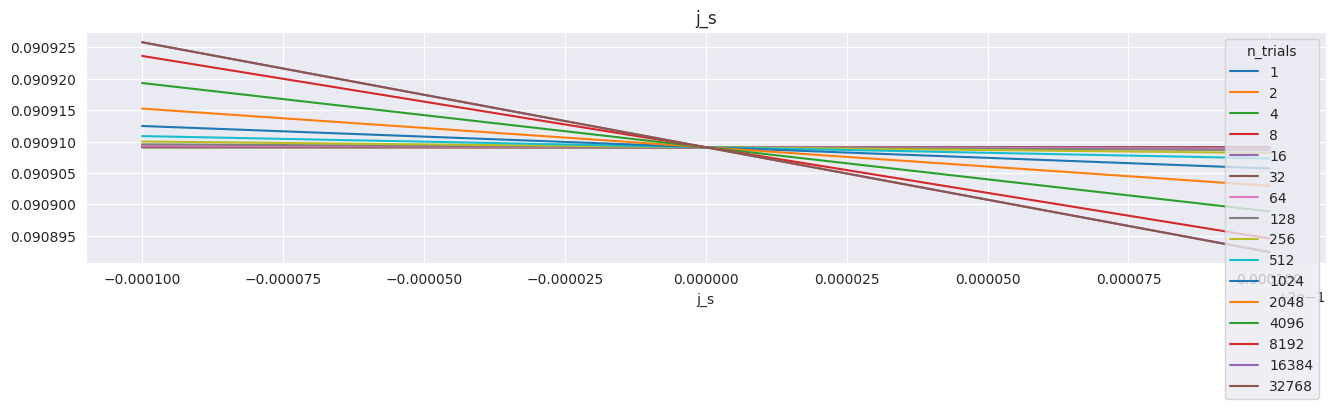

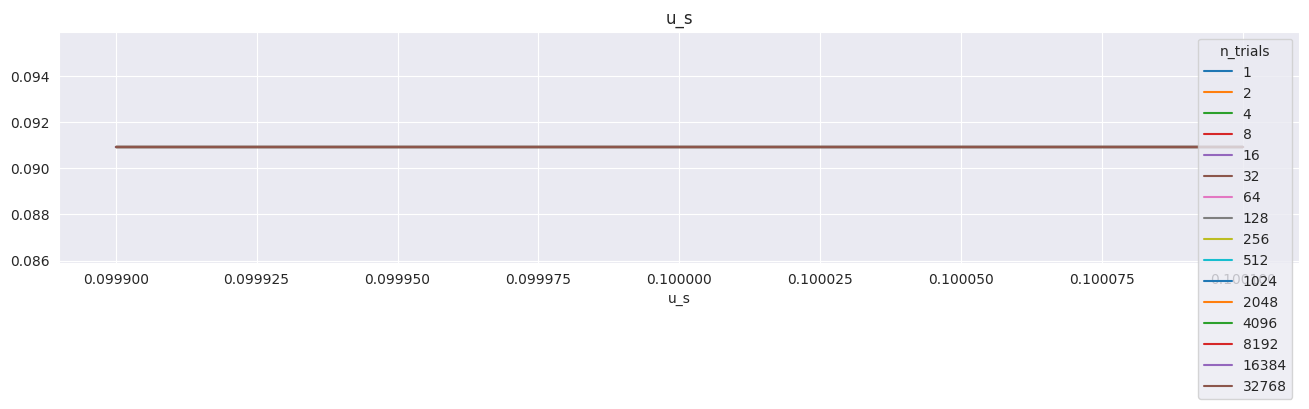

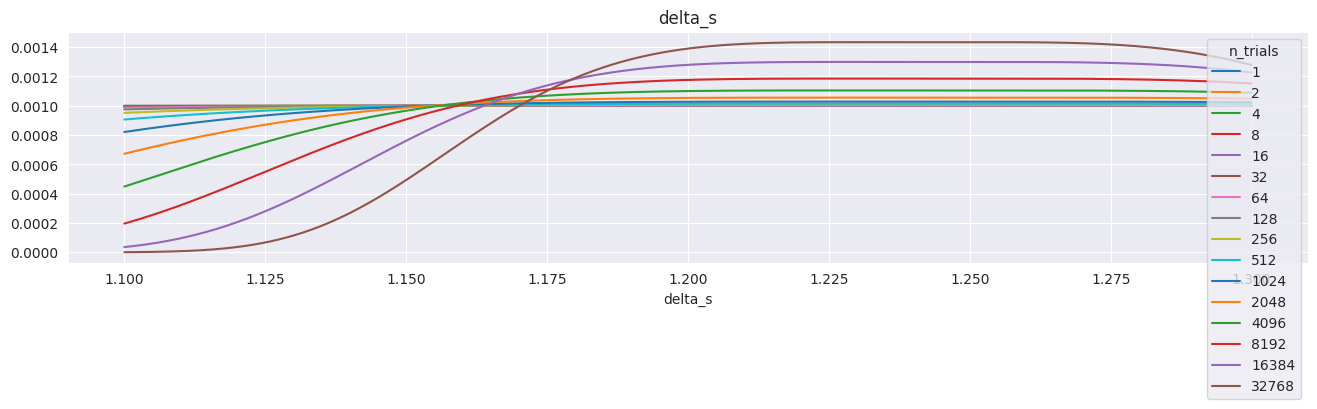

In [29]:
aggregates = pd.DataFrame()
for parameter in [par for par in true_values.keys() if len(set(df[par]))>=5]: # Only plot parameters for which we attempted at least 5 different values
    temp_df = df[[parameter, "n_trials", "log_likelihood"]]
    temp_df.sample(10)

    likelihood_df = temp_df\
    .groupby([parameter, "n_trials"])["log_likelihood"]\
    .agg(lambda row: np.sum(np.exp(row)))\
    .reset_index()\
    .pivot(columns="n_trials", index=parameter, values="log_likelihood")

    likelihood_df /= likelihood_df.sum(axis=0)
    # mean = np.divide(df["delta_s"] @ df["likelihood"], df["likelihood"].sum())
    likelihood_df.plot.line(figsize=(16,3), title=parameter)

    aggregates = pd.concat([aggregates, pd.DataFrame({
        "variable": parameter,
        "n_trials": likelihood_df.columns,
        "mean": likelihood_df.apply(lambda row: np.average(likelihood_df.index, weights=row), axis=0),
        "var": likelihood_df.apply(lambda row: np.average(row**2, weights=likelihood_df.index) - np.average(row, weights=likelihood_df.index**2, axis=0))
    })])


In [30]:
aggregates.pivot(index="n_trials", columns="variable", values="var")

variable,delta_s,j_s,u_s
n_trials,,,
1,-0.000998,-0.082645,-0.082645
2,-0.000998,-0.082645,-0.082645
4,-0.000998,-0.082645,-0.082645
8,-0.000998,-0.082645,-0.082645
16,-0.000998,-0.082645,-0.082645
32,-0.000998,-0.082645,-0.082645
64,-0.000998,-0.082645,-0.082645
128,-0.000998,-0.082645,-0.082645
256,-0.000999,-0.082645,-0.082645


<Axes: xlabel='n_trials'>

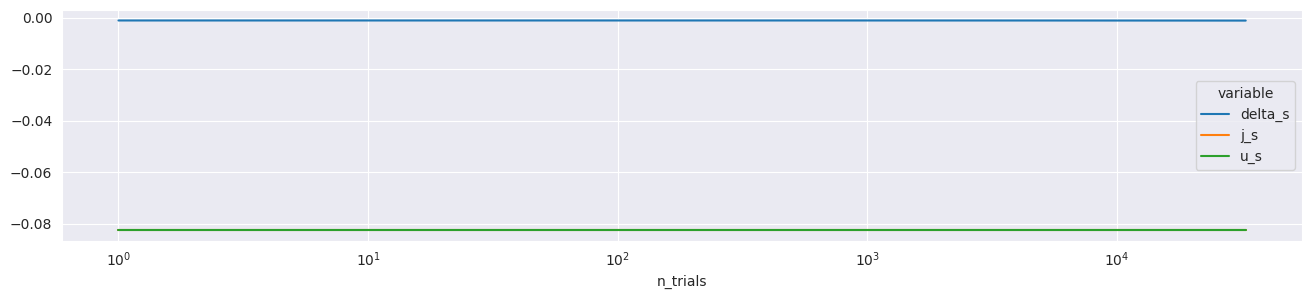

In [31]:
aggregates.pivot(index="n_trials", columns="variable", values="var").plot.line(figsize=(16,3),logx=True)

In [32]:
[2**x for x in range(17)]

[1,
 2,
 4,
 8,
 16,
 32,
 64,
 128,
 256,
 512,
 1024,
 2048,
 4096,
 8192,
 16384,
 32768,
 65536]